https://www.kaggle.com/yasufuminakama/ranzcr-resnext50-32x4d-starter-training

## Data Loading

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
os.listdir('./input')

['train_tfrecords',
 'sample_submission.csv',
 'train_annotations.csv',
 'test_tfrecords',
 'test',
 'train.csv',
 'train']

In [4]:
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/sample_submission.csv')

In [5]:
train.head()

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,0,0,ec89415d1
1,1.2.826.0.1.3680043.8.498.46302891597398758759...,0,0,1,0,0,1,0,0,0,1,0,bf4c6da3c
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5
3,1.2.826.0.1.3680043.8.498.68286643202323212801...,0,0,0,0,0,0,0,1,0,0,0,c31019814
4,1.2.826.0.1.3680043.8.498.10050203009225938259...,0,0,0,0,0,0,0,0,0,1,0,207685cd1


## Quick EDA

In [6]:
train['PatientID'].value_counts()

05029c63a    172
55073fece    167
26da0d5ad    148
8849382d0    130
34242119f    110
            ... 
2cde59f33      1
331d22fa0      1
e001492d4      1
cc06e6a6e      1
0f8543b07      1
Name: PatientID, Length: 3255, dtype: int64

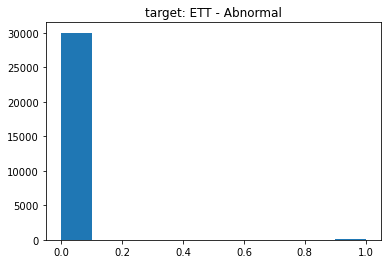

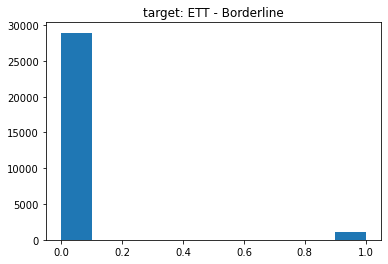

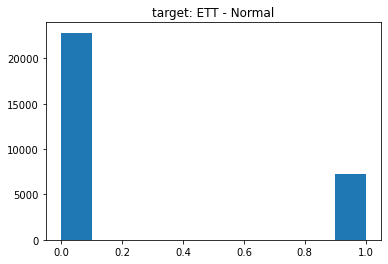

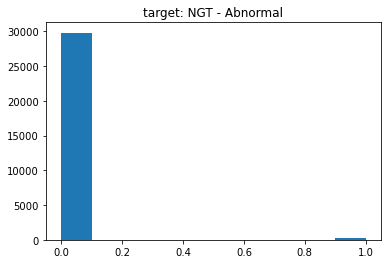

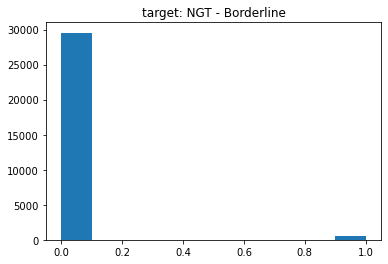

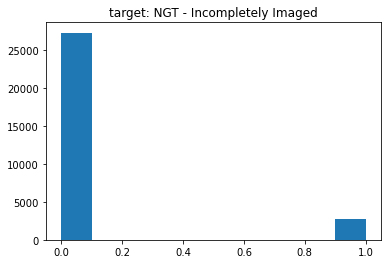

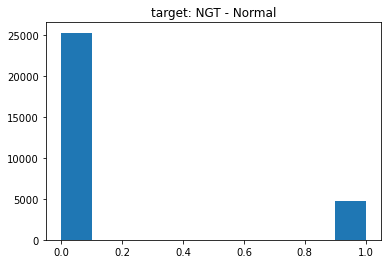

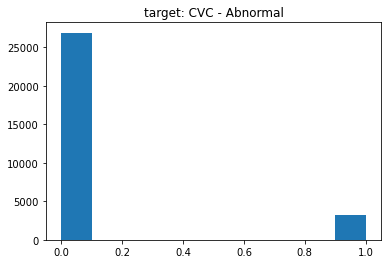

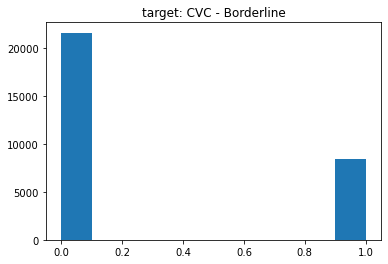

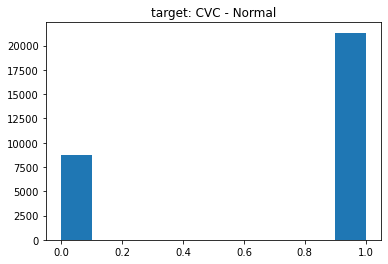

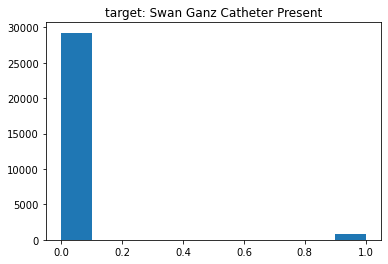

In [7]:
target_cols = train.drop(['StudyInstanceUID', 'PatientID'], 1).columns.tolist()
for c in target_cols :
    plt.hist(train[c].values)
    plt.title(f'target: {c}')
    plt.show()

## Directory Settings

In [55]:
import os
OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
TRAIN_PATH = './input/train'

## CFG

In [19]:
class CFG :
    debug = False
    print_freq = 100
    num_workers = 4
    model_name = 'resnext50_32x4d'
    size= 600
    scheduler = 'CosineAnnealingLR'
    epochs = 6
    T_max = 6
    lr = 1e-4
    min_lr = 1e-6
    batch_size = 32
    weight_decay = 1e-6
    gradient_accumulation_steps = 1
    max_grad_norm = 1000
    seed = 42
    target_size = 11
    target_cols = ['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal',
                 'NGT - Abnormal', 'NGT - Borderline', 'NGT - Incompletely Imaged', 'NGT - Normal', 
                 'CVC - Abnormal', 'CVC - Borderline', 'CVC - Normal',
                 'Swan Ganz Catheter Present']
    n_fold = 4
    trn_fold = [0, 1, 2, 3]
    train = True

if CFG.debug :
    CFG.epochs = 1
    train = train.sample(n = 100, random_state=CFG.seed).reset_index(drop = True)

In [10]:
import sys
sys.path.append('../input/pytorch-image-models/pytorch-image-models-master')

import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose
    )
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

from torch.cuda.amp import autocast, GradScaler

import warnings 
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Utils

* contextmanager에 대한 설명 : https://sjquant.tistory.com/12, contextmanager는 with문과 비슷한 기능을 하는 것으로 보임
* yield에 대한 설명 : https://kkamikoon.tistory.com/90, yield는 조금 더 공부 필요
* logger 모듈에 대한 설명 : https://greeksharifa.github.io/%ED%8C%8C%EC%9D%B4%EC%8D%AC/2019/12/13/logging/

In [21]:
def get_score(y_true, y_pred) :
    scores = []
    for i in range(y_true.shape[1]) : #열 추출
        score = roc_auc_score(y_true[:, i], y_pred[:, i]) #열별로 roc_auc_score 추출
        scores.append(score)
    
    avg_score = np.mean(scores)
    return avg_score, scores


@contextmanager
def timer(name) :
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')
    
    
def init_logger(log_file = OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter('%(message)s'))
    handler2 = FileHandler(filename = log_file)
    handler2.setFormatter(Formatter('%(message)s'))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    
    return logger

LOGGER = init_logger()

def seed_torch(seed=42) :
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_torch(seed=CFG.seed)

## CV split

In [27]:
folds = train.copy()
Fold = GroupKFold(n_splits = CFG.n_fold)
groups = folds['PatientID'].values
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_cols], groups)):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
folds.groupby('fold').size()

fold
0    7521
1    7521
2    7521
3    7520
dtype: int64

* GroupKFold는 지정한 Group 변수에 따라서 Kfold를 나눠주는 함수

## Dataset

In [65]:
class TrainDataset(Dataset) :
    def __init__(self, df, transform = None) :
        self.df = df
        self.file_names = df['StudyInstanceUID'].values
        self.labels = df[CFG.target_cols].values
        self.transform = transform
    
    def __len__(self) :
        return len(self.df)
    
    def __getitem__(self, idx) :
        file_name = self.file_names[idx]
        file_path = f'{TRAIN_PATH}/{file_name}.jpg'
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform :
            augmented = self.transform(image = image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).float()
        return image,label

In [40]:
def get_transforms(*, data) :
    if data == 'train' :
        return Compose([
            RandomResizedCrop(CFG.size, CFG.size, scale=(0.85, 1.0)),
            HorizontalFlip(p=0.5),
            Normalize(
                mean = [0.485, 0.456, 0.406],
                std = [0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
    elif data == 'valid' :
        return Compose([
            Resize(CFG.size, CFG.size),
            Normalize(
                mean= [0.485, 0.456, 0.406],
                std = [0.229, 0.224, 0.225]),
            ToTensorV2(),
        ]
        )

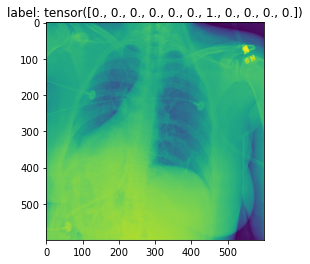

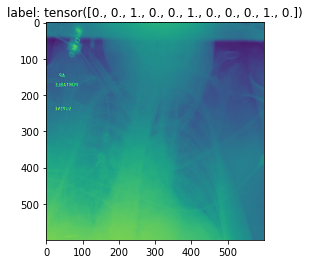

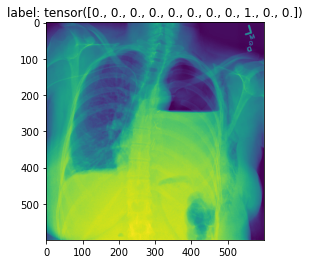

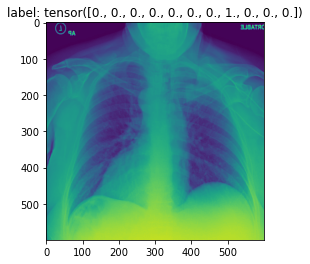

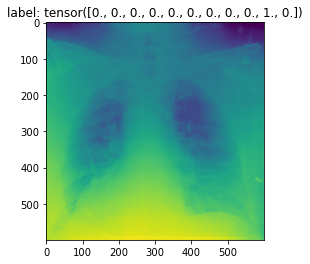

In [67]:
train_dataset = TrainDataset(train, transform = get_transforms(data='train'))

for i in range(5) :
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show()